In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medium-grib/slt.grib
/kaggle/input/medium-grib/data.grib
/kaggle/input/era5-land-monthly-averaged-data/data.grib
/kaggle/input/small-grib/41d3e2fd979903c14d071797a0a34f19.grib


In [10]:
!pip install earthengine-api cdsapi xarray pandas numpy tensorflow keras matplotlib seaborn folium geopandas -q



In [11]:
# Replace 'YOUR_UID' and 'YOUR_API_KEY' with your own info
cdsapirc_content = """
url: https://cds.climate.copernicus.eu/api
key: 0851c481-c996-4cad-9852-d5f4db1b2833
"""

# Save the file
with open('/root/.cdsapirc', 'w') as f:
    f.write(cdsapirc_content)

print("✅ .cdsapirc created successfully!")


✅ .cdsapirc created successfully!


In [4]:
!ls /kaggle/working/

41d3e2fd979903c14d071797a0a34f19.grib  era5_land_algeria_drought_1981_2024.grib
data


In [ ]:
# !cp /kaggle/working/41d3e2fd979903c14d071797a0a34f19.grib /kaggle/working/data/raw/41d3e2fd979903c14d071797a0a34f19.grib
# !cp /kaggle/working/era5_land_algeria_drought_1981_2024.grib /kaggle/working/data/raw/era5_land_algeria_drought_1981_2024.grib

In [5]:
! unzip "/kaggle/input/era5-land-monthly-averaged-data/data.grib" -d data


Archive:  /kaggle/input/era5-land-monthly-averaged-data/data.grib
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /kaggle/input/era5-land-monthly-averaged-data/data.grib or
        /kaggle/input/era5-land-monthly-averaged-data/data.grib.zip, and cannot find /kaggle/input/era5-land-monthly-averaged-data/data.grib.ZIP, period.


In [6]:
!ls /kaggle/working/data/raw


41d3e2fd979903c14d071797a0a34f19.grib
41d3e2fd979903c14d071797a0a34f19.grib.5b7b6.idx
era5_land_algeria_drought_1981_2024.grib
era5_land_algeria_temp_soil.nc


In [1]:
# Install netCDF4 support
!pip install netCDF4 -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 59.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.2 MB/s eta 0:00:00


In [2]:
!pip install --upgrade xarray
!pip install cfgrib -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.0 MB/s eta 0:00:0000:0100:01


In [ ]:

import xarray as xr

# ds = xr.load_dataset('/kaggle/input/small-grib/41d3e2fd979903c14d071797a0a34f19.grib',backend_kwargs={
#         'filter_by_keys': {'stepType': 'avgd'}
#     })
ds = xr.load_dataset('/kaggle/input/medium-grib/data.grib',    
    engine='cfgrib',
    backend_kwargs={"indexpath": ""})

print(ds)


In [22]:
!pip install pygrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 82.4 MB/s eta 0:00:00:00:0100:01


In [3]:
import xarray as xr
import pandas as pd

# Path to your file
file_path = '/kaggle/input/medium-grib/data.grib'

# List of stepTypes you want
step_types = ['avgid', 'avgua', 'avgd', 'avgad', 'avgas']

# Open each stepType dataset
datasets = []

for step_type in step_types:
    try:
        print(f"⏳ Trying stepType: {step_type}")
        ds = xr.open_dataset(
            file_path,
            engine='cfgrib',
            backend_kwargs={
                'filter_by_keys': {'stepType': step_type},
                'indexpath': ''  # do not save index files
            }
        )
        print(f"✅ Opened {step_type}: {list(ds.data_vars.keys())}")
        datasets.append(ds)
    except Exception as e:
        print(f"⚠️ Could not open {step_type} — {e}")

# Merge safely, ignoring conflicting coord values
ds_merged = xr.merge(datasets, compat='override')

print("\n🎯 Final merged dataset:")
print(ds_merged)

# Convert to DataFrame
df = ds_merged.to_dataframe().reset_index()

print("\n📄 DataFrame preview:")
print(df.head())
print(df.columns)
df_og = df.copy()


⏳ Trying stepType: avgid


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


✅ Opened avgid: ['t2m']
⏳ Trying stepType: avgua


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


✅ Opened avgua: ['src', 'swvl1']
⏳ Trying stepType: avgd


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


✅ Opened avgd: ['evabs']
⏳ Trying stepType: avgad


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


✅ Opened avgad: ['pev', 'e']
⏳ Trying stepType: avgas


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


✅ Opened avgas: ['pev', 'e']

🎯 Final merged dataset:
<xarray.Dataset> Size: 152MB
Dimensions:              (time: 135, latitude: 191, longitude: 211, step: 2)
Coordinates:
  * time                 (time) datetime64[ns] 1kB 2014-01-01 ... 2025-03-01
  * latitude             (latitude) float64 2kB 37.5 37.4 37.3 ... 18.6 18.5
  * longitude            (longitude) float64 2kB -9.0 -8.9 -8.8 ... 11.9 12.0
    number               int64 8B ...
  * step                 (step) timedelta64[ns] 16B 01:00:00 1 days
    surface              float64 8B ...
    valid_time           (time) datetime64[ns] 1kB ...
    depthBelowLandLayer  float64 8B ...
Data variables:
    t2m                  (time, latitude, longitude) float32 22MB ...
    src                  (time, latitude, longitude) float32 22MB ...
    swvl1                (time, latitude, longitude) float32 22MB ...
    evabs                (time, step, latitude, longitude) float32 44MB ...
    pev                  (time, latitude, longitude)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.84   1042965
           1       0.53      0.31      0.39    365087

    accuracy                           0.75   1408052
   macro avg       0.66      0.61      0.62   1408052
weighted avg       0.72      0.75      0.73   1408052



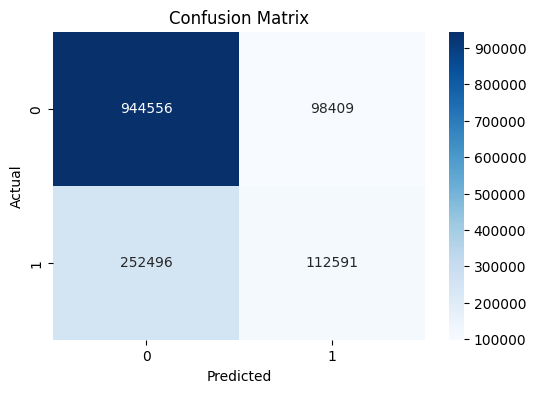

In [5]:

df = df_og.copy()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'df' is your loaded DataFrame

# Convert temperature from Kelvin to Celsius
df['t2m_celsius'] = df['t2m'] - 273.15

# Extract year and month from 'time'
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month

# Create lagged features for 't2m_celsius', 'pev', and 'e'
for var in ['t2m_celsius', 'pev', 'e']:
    for lag in [1, 2, 3]:
        df[f'{var}_lag_{lag}'] = df.groupby(['latitude', 'longitude'])[var].shift(lag)

# Create a future soil moisture value (3 months ahead)
df['swvl1_future'] = df.groupby(['latitude', 'longitude'])['swvl1'].shift(-3)

# Define drought label: 1 if future soil moisture is below 20th percentile
threshold = df['swvl1'].quantile(0.2)
df['drought_label'] = (df['swvl1_future'] < threshold).astype(int)

# Drop rows with missing values resulting from lagging
df = df.dropna()

# Define feature columns (excluding 'swvl1' and 'swvl1_future' to prevent data leakage)
feature_cols = [
    't2m_celsius', 'pev', 'e',
    't2m_celsius_lag_1', 'pev_lag_1', 'e_lag_1',
    't2m_celsius_lag_2', 'pev_lag_2', 'e_lag_2',
    't2m_celsius_lag_3', 'pev_lag_3', 'e_lag_3',
    'month'
]

# Split data into features (X) and target (y)
X = df[feature_cols]
y = df['drought_label']

# Split data into training and testing sets based on year
train_df = df[df['year'] <= 2020]
test_df = df[df['year'] > 2020]

X_train = train_df[feature_cols]
y_train = train_df['drought_label']
X_test = test_df[feature_cols]
y_test = test_df['drought_label']

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [6]:
df = df_og.copy()


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# -------------------------------
# 🧹 Feature Engineering
# -------------------------------

# Convert temperature from Kelvin to Celsius
df['t2m_celsius'] = df['t2m'] - 273.15

# Extract month as a feature
df['month'] = df['time'].dt.month

# Create lag features (1, 2, 3 months) for temperature, evap, and potential evap
for var in ['t2m_celsius', 'pev', 'e']:
    for lag in [1, 2, 3]:
        df[f'{var}_lag_{lag}'] = df.groupby(['latitude', 'longitude'])[var].shift(lag)

# Label droughts based on drop in soil moisture (swvl1)
df['swvl1_lag3'] = df.groupby(['latitude', 'longitude'])['swvl1'].shift(-3)
df['drought'] = (df['swvl1_lag3'] < df['swvl1']).astype(int)

# Drop rows with any missing values (from lagging or bad data)
df = df.dropna()

# -------------------------------
# 🧠 Model Training
# -------------------------------

# Define features and label
features = [
    't2m_celsius_lag_1', 'pev_lag_1', 'e_lag_1',
    't2m_celsius_lag_2', 'pev_lag_2', 'e_lag_2',
    't2m_celsius_lag_3', 'pev_lag_3', 'e_lag_3',
    'month'
]
target = 'drought'

# Train-test split
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Fit model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.58      0.64      0.61    554772
           1       0.61      0.55      0.58    566112

    accuracy                           0.60   1120884
   macro avg       0.60      0.60      0.60   1120884
weighted avg       0.60      0.60      0.60   1120884



In [ ]:


# # Load your dataframe (already merged and cleaned)
# # df = (already loaded previously)

# # 1. Prepare the data
# df['year'] = df['time'].dt.year
# df['month'] = df['time'].dt.month

# # Convert temperature from Kelvin to Celsius
# df['t2m_celsius'] = df['t2m'] - 273.15

# # 2. Create drought label:
# # Let's say if swvl1 (soil water) is very low -> drought
# threshold_swvl1 = df['swvl1'].quantile(0.2)  # bottom 20%
# df['drought_label'] = (df['swvl1'] < threshold_swvl1).astype(int)

# # 3. Lagging Features (for 1-3 months prediction)
# df = df.sort_values(['latitude', 'longitude', 'time'])
# for lag in [1, 2, 3]:
#     df[f't2m_lag_{lag}'] = df.groupby(['latitude', 'longitude'])['t2m_celsius'].shift(lag)
#     df[f'swvl1_lag_{lag}'] = df.groupby(['latitude', 'longitude'])['swvl1'].shift(lag)
#     df[f'pev_lag_{lag}'] = df.groupby(['latitude', 'longitude'])['pev'].shift(lag)
#     df[f'e_lag_{lag}'] = df.groupby(['latitude', 'longitude'])['e'].shift(lag)

# # 4. Drop missing values (from lagging)
# df = df.dropna()

# # 5. Feature selection
# features = [
#     't2m_celsius', 'swvl1', 'pev', 'e',
#     't2m_lag_1', 'swvl1_lag_1', 'pev_lag_1', 'e_lag_1',
#     't2m_lag_2', 'swvl1_lag_2', 'pev_lag_2', 'e_lag_2',
#     't2m_lag_3', 'swvl1_lag_3', 'pev_lag_3', 'e_lag_3',
#     'month'
# ]
# X = df[features]
# y = df['drought_label']

# # 6. Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # 7. Train Random Forest
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# # 8. Evaluate
# y_pred = model.predict(X_test)

# print("Classification Report:\n", classification_report(y_test, y_pred))

# # 9. Confusion matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.show()


In [16]:
import xarray as xr

# ds = xr.load_dataset('/kaggle/input/small-grib/41d3e2fd979903c14d071797a0a34f19.grib',backend_kwargs={
#         'filter_by_keys': {'stepType': 'avgd'}
#     })
slt_ds = xr.load_dataset('/kaggle/input/medium-grib/slt.grib',backend_kwargs={
        'filter_by_keys': {'stepType': 'avgd'}
    })

print(slt_ds)


<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.7
    history:      2025-04-28T23:44 GRIB to CDM+CF via cfgrib-0.9.15.0/ecCodes...


In [17]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt


# Convert to pandas dataframe
df = ds.to_dataframe().reset_index()

print(df.columns)



Index(['time', 'step', 'latitude', 'longitude', 'surface', 'valid_time',
       'evabs'],
      dtype='object')
